### Detailed EDA and Data Preparation

Run this notebook once to perform data engineering, plot visualizations and conduct Exploratory Data Analysis. 

In [40]:

# Import relevant libraries and environment
import os
import sys
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()

# Identify the project root (parent of current notebook folder)
project_root = Path.cwd().parent

# Define consistent base folders under the project root
data_root = project_root / "data"
reports_root = project_root / "reports"

# Define subdirectories
raw_dir        = data_root / "raw"
pre_proc_dir   = data_root / "pre-processed"
proc_dir       = data_root / "processed"
prepared_dir   = data_root / "prepared"       
eda_dir        = reports_root / "eda"          

# Create them if they don’t exist
for d in [raw_dir, pre_proc_dir, proc_dir, prepared_dir, eda_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Print confirmation
print("Dirs ready:")
print("  raw_dir       :", raw_dir)
print("  pre_proc_dir  :", pre_proc_dir)
print("  proc_dir      :", proc_dir)
print("  eda_dir       :", eda_dir)
print("  prepared_dir  :", prepared_dir)

Dirs ready:
  raw_dir       : c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\data\raw
  pre_proc_dir  : c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\data\pre-processed
  proc_dir      : c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\data\processed
  eda_dir       : c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\reports\eda
  prepared_dir  : c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\data\prepared


In [41]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from typing import Optional
from matplotlib.axes import Axes

# Load plot style and file coercing data type helper module
sys.path.append(str(Path.cwd().parent / "src"))

from plot_style import setup, COLORS, style_ax
from data_utils import standardize_online_retail_dtypes
setup()

In [42]:
# Read processed data file
online_retail_df = pd.read_csv("../data/processed/online_retail_processed.csv")

online_retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392391 entries, 0 to 392390
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392391 non-null  int64  
 1   StockCode    392391 non-null  object 
 2   Description  392391 non-null  object 
 3   Quantity     392391 non-null  int64  
 4   InvoiceDate  392391 non-null  object 
 5   UnitPrice    392391 non-null  float64
 6   CustomerID   392391 non-null  int64  
 7   Country      392391 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 23.9+ MB


In [43]:
# Check for missing values
online_retail_df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [44]:
# Apply centralized dtype standardization
standardize_online_retail_dtypes(online_retail_df)

# Verify the datatypes and cleaned CustomerID
online_retail_df.dtypes
online_retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [45]:
# Compute Revenue/Spend for each transaction
online_retail_df['Revenue'] = online_retail_df['Quantity'] * online_retail_df['UnitPrice']
online_retail_df.head()

# Cancellation Status- A transaction is "Cancelled" if InvoiceNo starts with 'C'
online_retail_df['Cancellation_Status'] = online_retail_df['InvoiceNo'].astype(str).apply(
    lambda x: 'Cancelled' if x.startswith('C') else 'Not Cancelled'
)

# Domestic vs International Customer
online_retail_df['Customer_Region'] = online_retail_df['Country'].apply(
    lambda x: 'Domestic' if x.strip().upper() == 'UNITED KINGDOM' else 'International'
)

online_retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Cancellation_Status,Customer_Region
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Not Cancelled,Domestic
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Not Cancelled,Domestic
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Not Cancelled,Domestic
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Not Cancelled,Domestic
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Not Cancelled,Domestic


In [46]:
# Count unique customers per region
cust_region = (
    online_retail_df.groupby('Customer_Region')['CustomerID']
      .nunique()
      .reset_index(name='Customer_Count')
)

# Calculate % of customers
cust_region['Customer_%'] = (
    cust_region['Customer_Count'] / cust_region['Customer_Count'].sum() * 100
)

# Percentage of revenue by region
rev_region = (
    online_retail_df.groupby('Customer_Region')['Revenue']
      .sum()
      .reset_index(name='Total_Revenue')
)

# Calculate % of revenue
rev_region['Revenue_%'] = (
    rev_region['Total_Revenue'] / rev_region['Total_Revenue'].sum() * 100
)

# Merge both summaries
region_summary = cust_region.merge(rev_region, on='Customer_Region')

# Round percentages for readability
region_summary['Customer_%'] = region_summary['Customer_%'].round(2)
region_summary['Revenue_%'] = region_summary['Revenue_%'].round(2)

# Display summary
print(region_summary)

  Customer_Region  Customer_Count  Customer_%  Total_Revenue  Revenue_%
0        Domestic            3920       90.47    7285024.644      82.01
1   International             413        9.53    1598223.230      17.99


In [47]:
# Save region summary in reports/eda
region_summary_path = eda_dir / "region_summary.csv"
region_summary.to_csv(region_summary_path, index=False)
print(f"[saved] Region summary to: {region_summary_path}")


[saved] Region summary to: c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\reports\eda\region_summary.csv


#### Figure 1: Weekly Orders and Revenue (Domestic vs International)

International customers place far fewer orders than UK customers, but their average order value (AOV = total revenue / number of orders) is much higher. Even though international transactions represent only about 10% of all orders, these purchases are typically larger in size and value. This explains the occasional revenue spikes for international markets in the weekly trend, while the UK remains the primary driver of overall sales and order volume.

[saved] c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\reports\eda\trend_weekly_orders_revenue_split.png


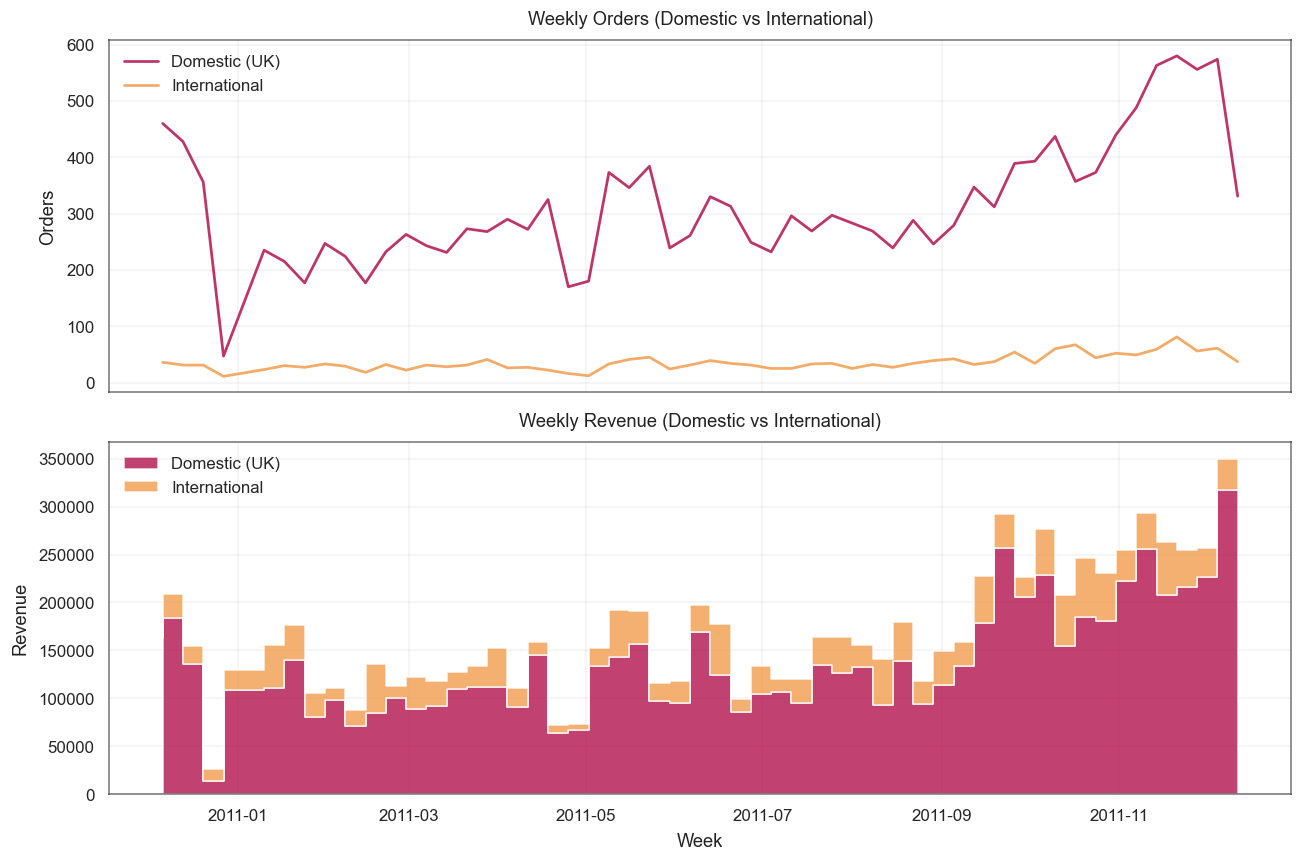

In [48]:
# Figure 01 Weekly Orders and Revenue (Domestic vs International)
# Weekly orders split by region
weekly_orders_region = (
    online_retail_df
      .groupby([pd.Grouper(key="InvoiceDate", freq="W-MON"), "Customer_Region"])["InvoiceNo"]
      .nunique()
      .unstack("Customer_Region")
      .fillna(0.0)
      .reset_index()
)

# Weekly revenue split by region
weekly_rev_region = (
    online_retail_df
      .groupby([pd.Grouper(key="InvoiceDate", freq="W-MON"), "Customer_Region"])["Revenue"]
      .sum()
      .unstack("Customer_Region")
      .fillna(0.0)
      .reset_index()
)

# Fetch Values
tot_orders = online_retail_df.groupby("Customer_Region")["InvoiceNo"].nunique()
tot_rev = online_retail_df.groupby("Customer_Region")["Revenue"].sum()
uk_orders = float(tot_orders["Domestic"])
int_orders = float(tot_orders["International"])
uk_rev = float(tot_rev["Domestic"])
int_rev = float(tot_rev["International"])
orders_int_pct = 100 * int_orders / (uk_orders + int_orders)
rev_uk_pct = 100 * uk_rev / (uk_rev + int_rev)
aov_uk = uk_rev / uk_orders
aov_int = int_rev / int_orders

# Create figures and axes
uk_c, intl_c = COLORS["uk"], COLORS["intl"]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Ax1 Weekly Orders (lines)
ax1.plot(weekly_orders_region["InvoiceDate"], weekly_orders_region["Domestic"], label="Domestic (UK)", linewidth=1.8, color=uk_c, alpha=0.9)
ax1.plot(weekly_orders_region["InvoiceDate"], weekly_orders_region["International"], label="International", linewidth=1.8, color=intl_c, alpha=0.9)
style_ax(ax1, title="Weekly Orders (Domestic vs International)", xlabel="", ylabel="Orders", legend_loc="upper left")

# Ax2 Weekly Revenue (stacked area)
x = weekly_rev_region["InvoiceDate"]
y_dom = weekly_rev_region["Domestic"].to_numpy()
y_int = weekly_rev_region["International"].to_numpy()
ax2.stackplot(x, y_dom, y_int, labels=["Domestic (UK)", "International"], colors=[uk_c, intl_c], step="pre", alpha=0.85)
style_ax(ax2, title="Weekly Revenue (Domestic vs International)", xlabel="Week", ylabel="Revenue", legend_loc="upper left")

fig.tight_layout()
out_path = eda_dir / "trend_weekly_orders_revenue_split.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print(f"[saved] {out_path}")
plt.show()

#### Figure 2: Market Snapshot, Orders, Revenue, and AOV (Domestic vs International)

The United Kingdom leads in both the number of orders and total revenue, but international customers contribute a noticeably larger share of revenue relative to their order volume. This pattern reflects their higher Average Order Value (AOV), meaning that each international purchase tends to be more valuable. Overall, the UK provides high transaction volume, while international customers add value through higher spending per order—highlighting two complementary sources of commercial strength.

[saved] c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\reports\eda\market_snapshot_orders_revenue_aov.png


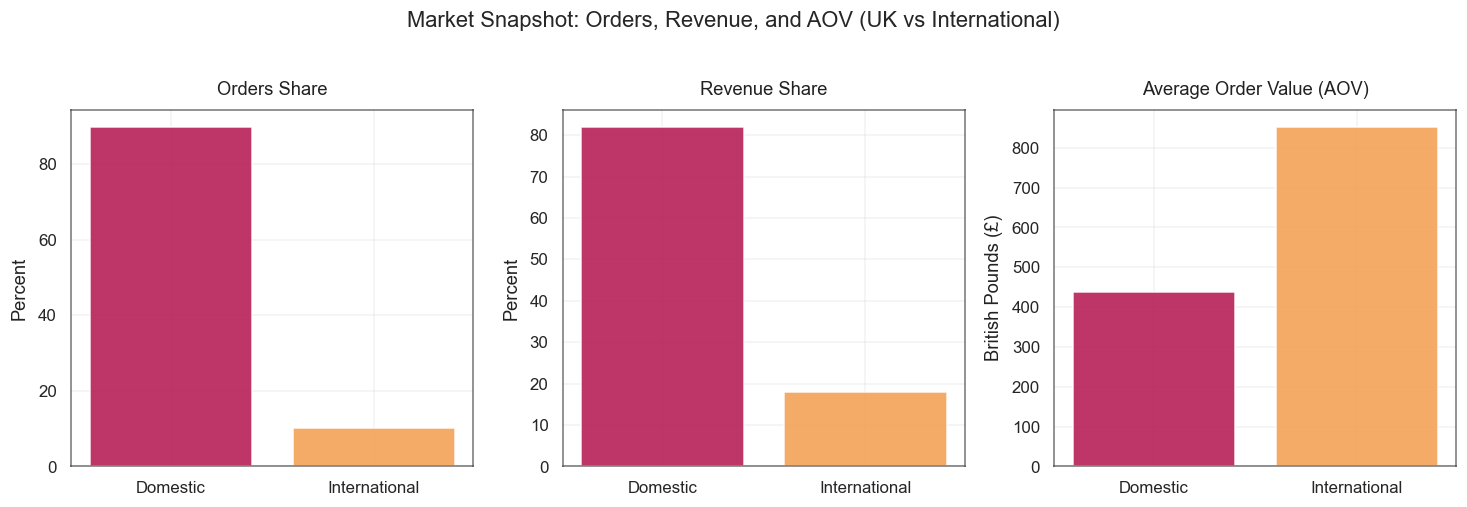

In [49]:
# Figure 02 Market Snapshot, Orders, Revenue, and AOV (Domestic vs International)
# Fetch base aggregates
orders_by_region = online_retail_df.groupby("Customer_Region")["InvoiceNo"].nunique().rename("Orders")
revenue_by_region = online_retail_df.groupby("Customer_Region")["Revenue"].sum().rename("Revenue")

snap = (
    pd.concat([orders_by_region, revenue_by_region], axis=1)
      .reset_index()
      .rename(columns={"Customer_Region": "Region"})
)

# Shares and AOV
snap["Orders_%"] = snap["Orders"]  / snap["Orders"].sum()  * 100
snap["Revenue_%"] = snap["Revenue"] / snap["Revenue"].sum() * 100
snap["AOV"] = snap["Revenue"] / snap["Orders"]

# Order bars: Domestic (UK), International
snap = snap.set_index("Region").loc[["Domestic", "International"]].reset_index()
colors = [COLORS["uk"], COLORS["intl"]]

# Create figures and axes
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5))

# Orders in percentage
ax = axes[0]
ax.bar(snap["Region"], snap["Orders_%"], color=colors, alpha=0.9)
style_ax(ax, title="Orders Share", xlabel="", ylabel="Percent")

# Revenue in percentage
ax = axes[1]
ax.bar(snap["Region"], snap["Revenue_%"], color=colors, alpha=0.9)
style_ax(ax, title="Revenue Share", xlabel="", ylabel="Percent")

# AOV (£ per order)
ax = axes[2]
ax.bar(snap["Region"], snap["AOV"], color=colors, alpha=0.9)
style_ax(ax, title="Average Order Value (AOV)", xlabel="", ylabel="British Pounds (£)")

fig.suptitle("Market Snapshot: Orders, Revenue, and AOV (UK vs International)", y=1.02)
fig.tight_layout()

out_path = eda_dir / "market_snapshot_orders_revenue_aov.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print(f"[saved] {out_path}")
plt.show()

#### Figure 3: Monthly Average Order Value (AOV) by Market (UK vs International)

Throughout the year, international customers consistently show a higher Average Order Value (AOV) than those in the UK. While order volumes vary from month to month, international purchases remain larger and higher in value. UK orders, on the other hand, are smaller but more frequent. This contrast suggests that the UK provides steady sales activity, whereas international markets deliver fewer but more profitable transactions.

[saved] c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\reports\eda\monthly_aov_by_market.png


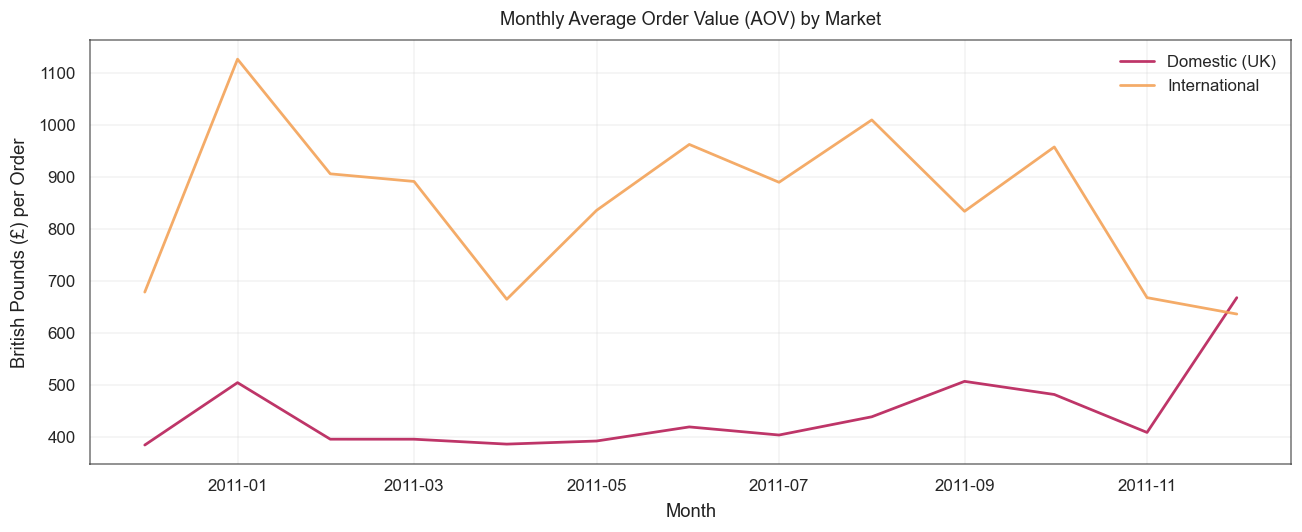

In [50]:
# Figure 03 Monthly Average Order Value (AOV) by Market (UK vs International)
# Monthly revenue and orders by market
monthly = (
    online_retail_df
      .groupby([pd.Grouper(key="InvoiceDate", freq="MS"), "Customer_Region"])
      .agg(
          Revenue=("Revenue", "sum"),
          Orders=("InvoiceNo", "nunique"),
      )
      .reset_index()
)

# Compute AOV
monthly["AOV"] = monthly["Revenue"] / monthly["Orders"]

# Split for plotting
uk  = monthly[monthly["Customer_Region"] == "Domestic"]
intl = monthly[monthly["Customer_Region"] == "International"]

# Create figures and axes
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(uk["InvoiceDate"], uk["AOV"],  linewidth=1.8, color=COLORS["uk"],   label="Domestic (UK)", alpha=0.9)
ax.plot(intl["InvoiceDate"], intl["AOV"], linewidth=1.8, color=COLORS["intl"], label="International", alpha=0.9)

style_ax(ax,
         title="Monthly Average Order Value (AOV) by Market",
         xlabel="Month",
         ylabel="British Pounds (£) per Order",
         legend_loc="upper right")

fig.tight_layout()
out_path = eda_dir / "monthly_aov_by_market.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print(f"[saved] {out_path}")
plt.show()

#### Recency, Frequency and Monetary (RFM) Analysis

In [51]:
# Recency of purchase
# Reference date: last date in the dataset
recent_pur_date = online_retail_df['InvoiceDate'].max()

# Compute recency (in days) for each customer
recency_df = online_retail_df.groupby('CustomerID', as_index=False)['InvoiceDate'].max()
recency_df['Recency'] = (recent_pur_date - recency_df['InvoiceDate']).dt.days


# Transaction frequency
frequency_df = online_retail_df.groupby('CustomerID', as_index=False)['InvoiceNo'].nunique()
frequency_df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)


# Monetary (total revenue per customer)
monetary_df = online_retail_df.groupby('CustomerID', as_index=False)['Revenue'].sum()
monetary_df.rename(columns={'Revenue': 'Monetary'}, inplace=True)


# Merge RFM components
rfm = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')


# Combine with customer info (region, country)
rfm = rfm.merge(online_retail_df[['CustomerID', 'Country', 'Customer_Region']].drop_duplicates(),
                on='CustomerID', how='left')

# Display head
print(rfm.head())

  CustomerID         InvoiceDate  Recency  Frequency  Monetary  \
0      12346 2011-01-18 10:01:00      325          1  77183.60   
1      12347 2011-12-07 15:52:00        1          7   4310.00   
2      12348 2011-09-25 13:13:00       74          4   1797.24   
3      12349 2011-11-21 09:51:00       18          1   1757.55   
4      12350 2011-02-02 16:01:00      309          1    334.40   

          Country Customer_Region  
0  United Kingdom        Domestic  
1         Iceland   International  
2         Finland   International  
3           Italy   International  
4          Norway   International  


In [52]:
# Remove InvoiceDate from rfm data frame
rfm = rfm.drop(columns=['InvoiceDate'])

In [53]:
# Verify the changes
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Country,Customer_Region
0,12346,325,1,77183.60,United Kingdom,Domestic
1,12347,1,7,4310.00,Iceland,International
2,12348,74,4,1797.24,Finland,International
3,12349,18,1,1757.55,Italy,International
4,12350,309,1,334.40,Norway,International


In [54]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4341 entries, 0 to 4340
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       4341 non-null   string 
 1   Recency          4341 non-null   int64  
 2   Frequency        4341 non-null   int64  
 3   Monetary         4341 non-null   float64
 4   Country          4341 non-null   string 
 5   Customer_Region  4341 non-null   object 
dtypes: float64(1), int64(2), object(1), string(2)
memory usage: 203.6+ KB


In [55]:
# Save this dataframe into csv file
rfm_path = prepared_dir / "rfm.csv"
rfm.to_csv(rfm_path, index=False)
print(f"[saved] RFM data to: {rfm_path}")


[saved] RFM data to: c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\data\prepared\rfm.csv


In [56]:
# Divide dataset into two markets, domestic and internatioal
rfm_domestic = rfm[rfm['Customer_Region'] == 'Domestic']
rfm_international = rfm[rfm['Customer_Region'] == 'International']

In [57]:
rfm_domestic.head()

,CustomerID,Recency,Frequency,Monetary,Country,Customer_Region
0,12346,325,1,77183.60,United Kingdom,Domestic
331,12747,1,11,4196.01,United Kingdom,Domestic
332,12748,0,209,33053.19,United Kingdom,Domestic
333,12749,3,5,4090.88,United Kingdom,Domestic
378,12820,2,4,942.34,United Kingdom,Domestic


In [58]:
rfm_international.head()

,CustomerID,Recency,Frequency,Monetary,Country,Customer_Region
1,12347,1,7,4310.00,Iceland,International
2,12348,74,4,1797.24,Finland,International
3,12349,18,1,1757.55,Italy,International
4,12350,309,1,334.40,Norway,International
5,12352,35,8,2506.04,Norway,International


In [59]:
# Save this domestic dataframe into csv file
rfm_domestic_path = prepared_dir / "rfm_domestic.csv"
rfm_domestic.to_csv(rfm_domestic_path, index=False)
print(f"[saved] RFM domestic data to: {rfm_domestic_path}")

# Save this international dataframe into csv file
rfm_international_path = prepared_dir / "rfm_international.csv"
rfm_international.to_csv(rfm_international_path, index=False)
print(f"[saved] RFM international data to: {rfm_international_path}")



[saved] RFM domestic data to: c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\data\prepared\rfm_domestic.csv
[saved] RFM international data to: c:\Users\jjsos\Documents\DSI_7\team_project\ds08_online-retail\data\prepared\rfm_international.csv


| Metric            | Definition                   | Typical interpretation          |
| ----------------- | ---------------------------- | ------------------------------- |
| **Recency (R)**   | Days since the last purchase | Lower = better (more recent)    |
| **Frequency (F)** | Number of transactions       | Higher = better (more loyal)    |
| **Monetary (M)**  | Total spend                  | Higher = better (more valuable) |
